# The Simulator Class

The most convenient way to use ``hera_sim`` is to use the ``Simulator`` class, which builds in all the primary functionality of the ``hera_sim`` package in an easy-to-use interface, and adds the ability to consistently write all produced effects into a ``pyuvdata.UVData`` object (and to file).

What follows is a quick tour of the main functionality this provides.

## Setup

In [1]:
from hera_sim.simulate import Simulator

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import uvtools

from hera_sim.noise import HERA_Tsky_mdl
from hera_sim.data import DATA_PATH

## The Simulator Class

The ``Simulator`` class holds everything required to generate and do basic analysis on a simulation. It can be instantiated either by submitting a filename pointing to an existing  simulation (in uvfits, uvh5 or miriad format), *or* a set of keyword arguments which are passed to the ``hera_sim.io.empty_uvdata`` function. The following are all the required arguments, plus an argument to set the total time of the observation to about 12 hours:

In [2]:
sim = Simulator(
    n_freq = 1024,
    n_times = 500,
    antennas = {
        0: (20.0, 20.0, 0),
        1: (50.0, 50.0, 0)
    },
    no_autos=True,   # model only one baseline
    integration_time=3600*12./500, # roughly 12 hours of total time
)

Note that you don't _need_ to pass ``antpairs``. By default it will use all pairs of antennas (but not the conjugates). You can specify exact pairs to use as a list of tuples, or use a number of default presets, such as "EW" for only East-West aligned baselines, or "redundant" for redundant baseline _groups_.

This will instantiate a ``UVData`` object, which can be accessed via the ``data`` attribute of the object.

In [3]:
sim.data

In [4]:
sim.antpos

{0: array([ 2.00000000e+01,  2.00000000e+01, -4.53549731e-09]),
 1: array([ 5.00000000e+01,  5.00000000e+01, -4.40831371e-09])}

We'll use a standard waterfall plot throughout the notebook to show the progress of the simulation:

In [5]:
def waterfall(
    vis, freq=sim.data.freq_array[0]/1e6, lsts=sim.data.lst_array, 
    vmax=None, vrange=None, title=None,
):
    """
    A wrapper around the uvtools' waterfall function providing some
    extra labelling and plot adjustment.
    """
    fig, ax = plt.subplots(
        2,1, sharex=True, sharey=True, figsize=(12,10)
    )
    
    if title is not None:
        ax[0].set_title(title, fontsize=12)
    plt.sca(ax[0])
    uvtools.plot.waterfall(
        vis[:,0,:,0], mode='log', mx=vmax, drng=vrange,
        extent=(freq.min(), freq.max(), lsts.min(), lsts.max())
    )
    plt.colorbar(label=r'log$_{10}$(Vis/Jy)')
    plt.ylabel("LST", fontsize=12)
    
    plt.sca(ax[1])
    uvtools.plot.waterfall(
        vis[:,0,:,0], 
        mode='phs',
        extent=(freq.min(), freq.max(), lsts.min(), lsts.max())
    )
    plt.colorbar(label='Phase [rad]')
    plt.xlabel("Frequency [MHz]", fontsize=12)
    plt.ylabel("LST", fontsize=12)
    

## Adding Effects

All simulated effects offered by the ``Simulator`` class are defined as methods beginning with ``add_``. Most of these methods have as their first parameter a *model*, which defines which model of the particular component to add. For example, the ``add_foregrounds`` method can accept ``"diffuse_foreground"`` or ``"pntsrc_foreground"``. These can be passed as strings or callable functions. 

Also, all ``add_xxx`` models have the option to _not_ add their calculated visibilities to the data, and also the ability to return just visibilities from that particular model. We will show a couple of these examples in the following, but note that this keywords apply to _all_ models.

### Foregrounds

In [6]:
sim.add_foregrounds(
    "diffuse_foreground",
    Tsky_mdl = HERA_Tsky_mdl['xx']
)

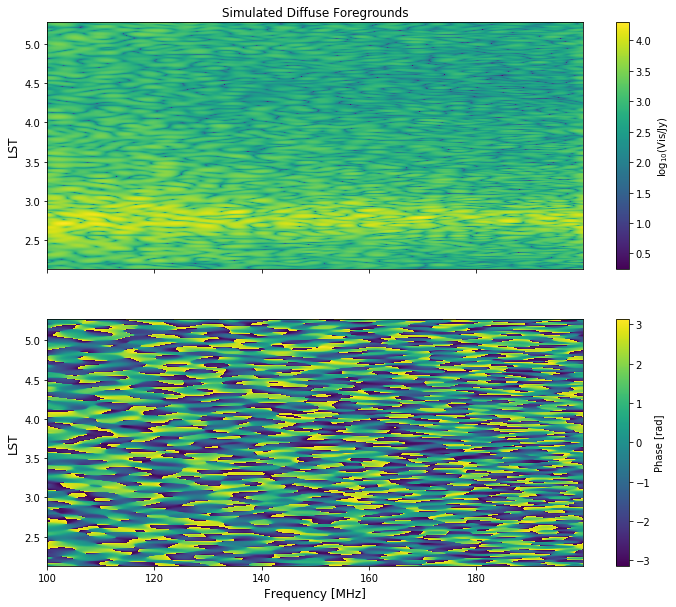

In [7]:
waterfall(sim.data.data_array, title='Simulated Diffuse Foregrounds')

In [8]:
sim.add_foregrounds(
    "pntsrc_foreground",
    nsrcs = 5000
)

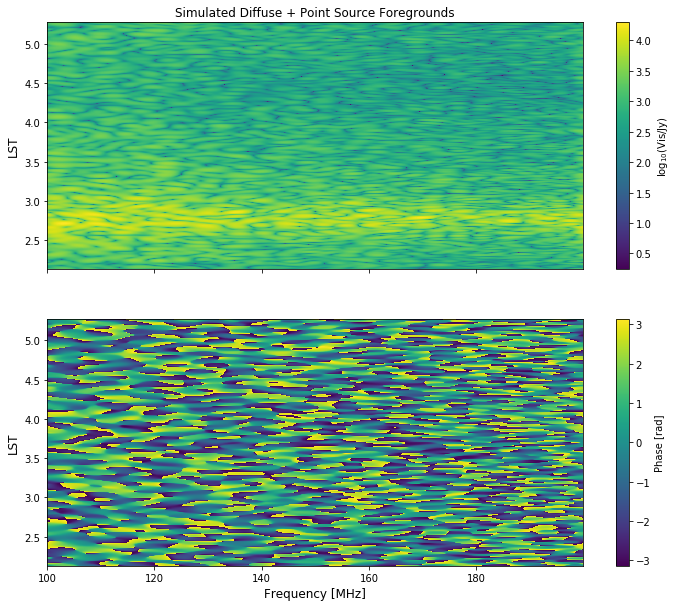

In [9]:
waterfall(sim.data.data_array, title='Simulated Diffuse + Point Source Foregrounds')

### EoR

In this case, we'll use a pre-defined function, instead of the string. 

Also, instead of adding the visibilities to the data, let's just return the visibilities so that we can see the purely EoR waterfall:

In [10]:
from hera_sim import eor

eor_vis = sim.add_eor(
    model=eor.noiselike_eor,
    add_vis = False
)

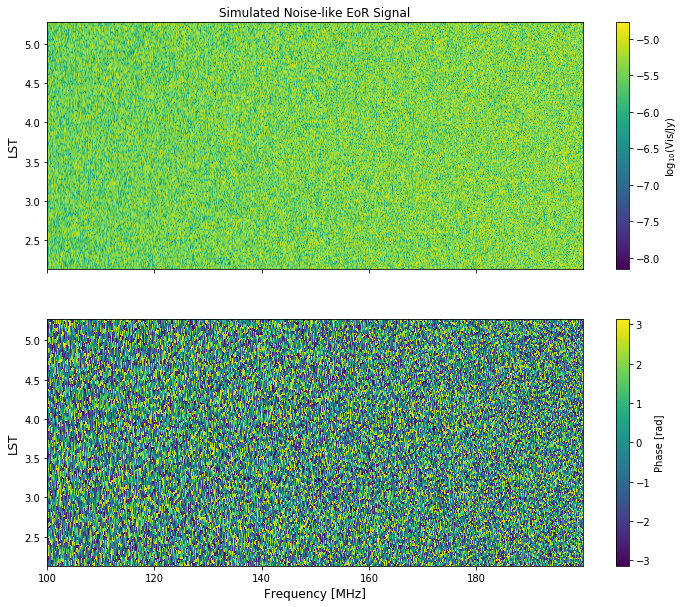

In [11]:
# remove any divide-by-zero errors for taking the logarithm
eor_vis = np.where(eor_vis==0, 1, eor_vis)
waterfall(eor_vis, title='Simulated Noise-like EoR Signal')

If we had wanted to _both_ return the visibilities, _and_ add them to the underlying data:

In [12]:
eor_vis = sim.add_eor(
    model=eor.noiselike_eor,
    ret_vis = True
)

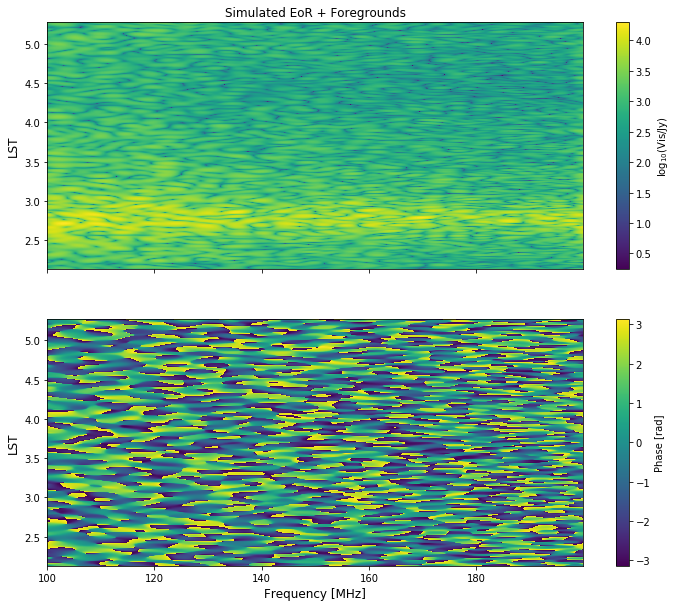

In [13]:
waterfall(sim.data.data_array, title='Simulated EoR + Foregrounds')

### Noise

In [14]:
sim.add_noise(
    "thermal_noise",
    Tsky_mdl = HERA_Tsky_mdl['xx'],
    Trx = 150.0
)

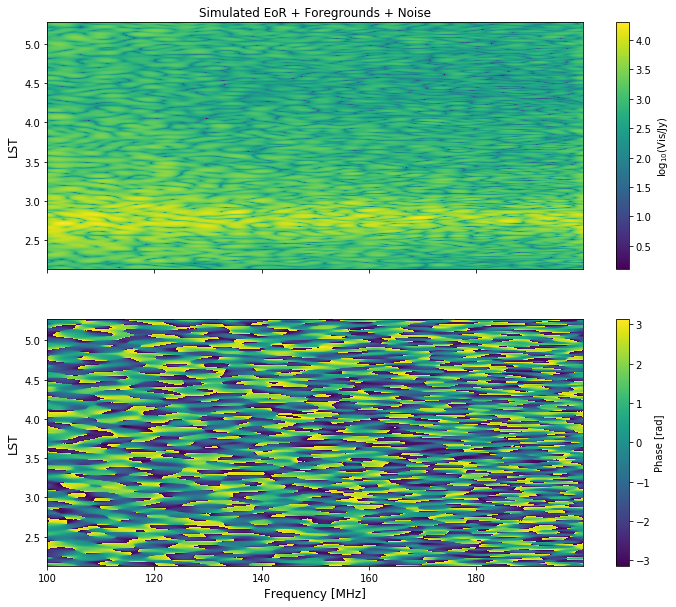

In [15]:
waterfall(sim.data.data_array, title='Simulated EoR + Foregrounds + Noise')

### RFI

In [16]:
sim.add_rfi(
    "rfi_stations",
)

sim.add_rfi(
    "rfi_impulse",
    chance=0.01,
    strength=100.0
)

sim.add_rfi(
    "rfi_scatter",
    chance=0.001, 
    strength=20,
    std = 5
)

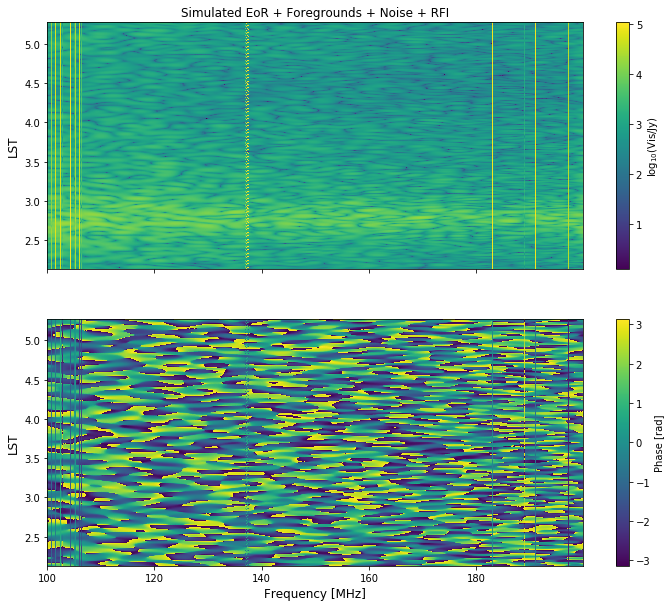

In [17]:
waterfall(sim.data.data_array, title='Simulated EoR + Foregrounds + Noise + RFI')

### Gains

In [18]:
sim.add_gains()

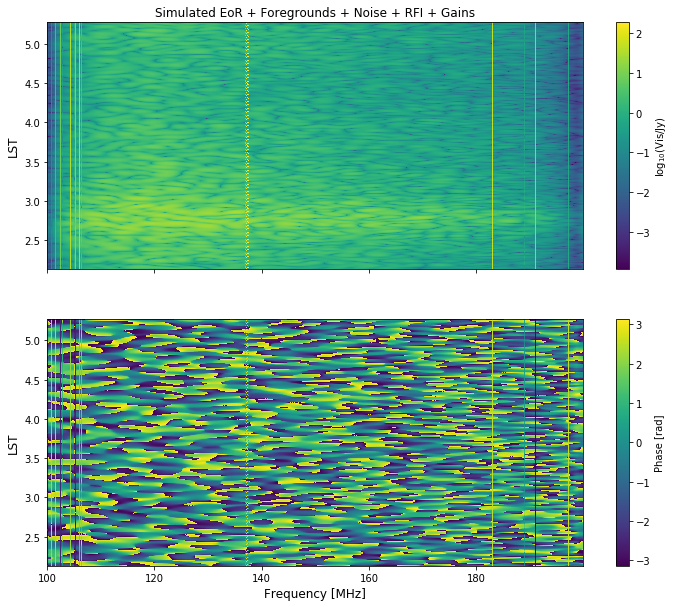

In [19]:
waterfall(sim.data.data_array, title='Simulated EoR + Foregrounds + Noise + RFI + Gains')

### Reflections

In [20]:
sim.add_sigchain_reflections(
    amp=[1.0,1.0],
    dly=[10.0,10.0],
    phs=[1.0,1.0]
)

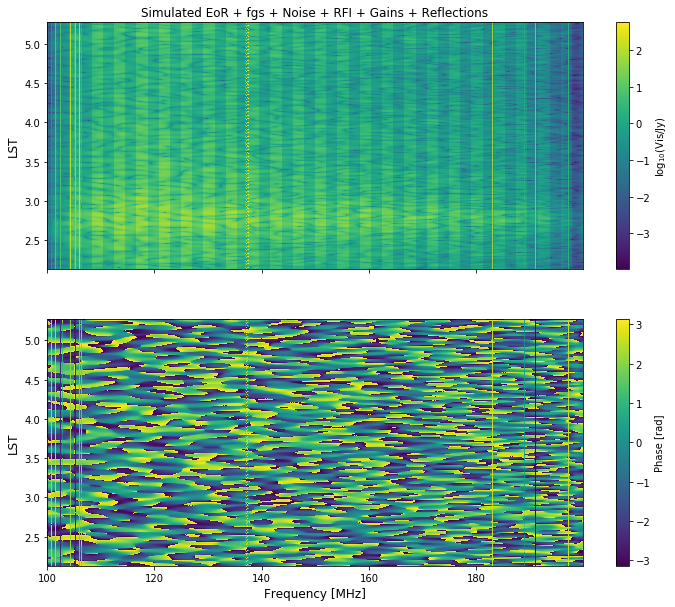

In [21]:
waterfall(sim.data.data_array, title='Simulated EoR + fgs + Noise + RFI + Gains + Reflections')

### Crosstalk

In [22]:
sim.add_xtalk( 'gen_whitenoise_xtalk',
    amplitude=0.001
)

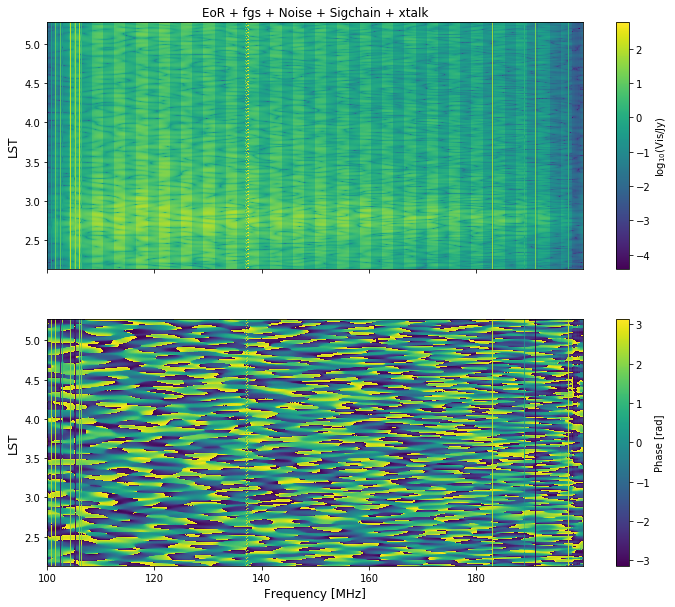

In [23]:
waterfall(sim.data.data_array, title='EoR + fgs + Noise + Sigchain + xtalk')

## Ordering of Effects

Some of the effects that can be simulated act on visibilities additively, whereas others act multiplicatively. The `Simulator` class keeps track of the order in which simulation components have been added, and issues warnings if the simulation components have been added out of order. In particular, it issues warnings if a multiplicative model is added to an empty set of visibilities or if an absolute visibility is added after a multiplicative effect has been added.

In [24]:
sim.add_eor("noiselike_eor")

You are adding absolute visibilities _after_ determining visibilities that should depend on these. Please re-consider.


## Inspecting the results

Each modelling component automatically adds itself to the ``UVData`` object's history, which can be inspected:

In [25]:
print(sim.data.history)

  Downselected to specific antenna pairs using pyuvdata.
hera_sim v0.0.1: Added foregrounds using diffuse_foreground with kwargs: {'Tsky_mdl': <scipy.interpolate.fitpack2.RectBivariateSpline object at 0x7f8fb7c302b0>}
hera_sim v0.0.1: Added foregrounds using pntsrc_foreground with kwargs: {'nsrcs': 5000}
hera_sim v0.0.1: Added eor using noiselike_eor with kwargs: {}
hera_sim v0.0.1: Added noise using thermal_noise with kwargs: {'Tsky_mdl': <scipy.interpolate.fitpack2.RectBivariateSpline object at 0x7f8fb7c302b0>, 'Trx': 150.0}
hera_sim v0.0.1: Added rfi using rfi_stations with kwargs: {}
hera_sim v0.0.1: Added rfi using rfi_impulse with kwargs: {'chance': 0.01, 'strength': 100.0}
hera_sim v0.0.1: Added rfi using rfi_scatter with kwargs: {'chance': 0.001, 'strength': 20, 'std': 5}
hera_sim v0.0.1: Added gains with kwargs: {}
hera_sim v0.0.1: Added sigchainreflections with kwargs: {'amp': [1.0, 1.0], 'dly': [10.0, 10.0], 'phs': [1.0, 1.0]}
hera_sim v0.0.1: Added xtalk using gen_whitenois

The simulation can be also written to file:

In [26]:
#sim.write_data("hera_simulation.uvh5")

## The run_sim Method

The `Simulator` class features a `run_sim` method, which serves as a one-stop shop for running a simulation using the tools available in `hera_sim`. This method accepts either a hook to a YAML file or a dictionary of simulation parameters as an argument and uses these simulation parameters to add all of the requested simulation components to the `Simulator` object that called the method. The following cells provide an example of how to use the `run_sim` method.  
  
**Note**: the `run_sim` method is not supported on Python 2. You will need to switch to Python 3.4 (or a later version) in order to use the `run_sim` method.

In [27]:
# first, make a fresh Simulator object
sim = Simulator(n_freq=1024, n_times=500, integration_time=10.7, 
                antennas={0:(20,20,0),1:(50,50,0)}, no_autos=True)

In [28]:
# to see which models are available for simulation:
for component in Simulator.SIMULATION_COMPONENTS.keys():
    print(component)

noiselike_eor
diffuse_foreground
pntsrc_foreground
thermal_noise
rfi_stations
rfi_impulse
rfi_scatter
rfi_dtv
gains
sigchain_reflections
gen_whitenoise_xtalk
gen_cross_coupling_xtalk


In [29]:
# first example: with a dictionary of simulation parameters
# the dictionary must be formatted as {'model_name':{'model_param':param_value}}

sim_params = {
    'diffuse_foreground': {'Tsky_mdl': HERA_Tsky_mdl['xx']},
    'pntsrc_foreground': {'nsrcs': 2500, 'Smin': 0.1},
    'gains': {},
    'noiselike_eor': {'eor_amp': 3e-2},
    'sigchain_reflections': {'amp': [0.89,0.75], 'dly': [13,8], 'phs': [1.23, 4.56]},
    'gen_whitenoise_xtalk': {'amplitude': 0.01},
    'thermal_noise': {'Tsky_mdl': HERA_Tsky_mdl['xx'], 'Trx': 100},
    'rfi_dtv': {}
}

In [30]:
# now run the simulation according to what's listed in sim_params
sim.run_sim(**sim_params)

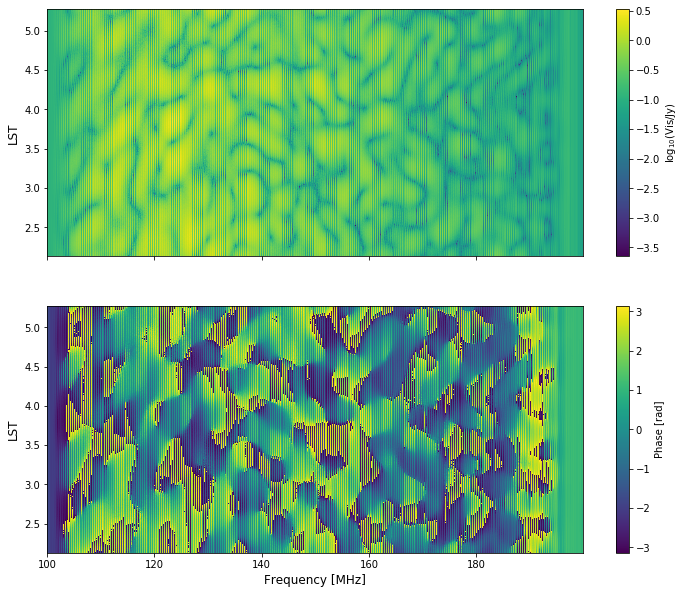

In [31]:
# check out how it looks
waterfall(sim.data.data_array)

In [32]:
print(sim.data.history)

  Downselected to specific antenna pairs using pyuvdata.
hera_sim v0.0.1: Added eor using noiselike_eor with kwargs: {'eor_amp': 0.03}
hera_sim v0.0.1: Added foregrounds using diffuse_foreground with kwargs: {'Tsky_mdl': <scipy.interpolate.fitpack2.RectBivariateSpline object at 0x7f8fb7c302b0>}
hera_sim v0.0.1: Added foregrounds using pntsrc_foreground with kwargs: {'nsrcs': 2500, 'Smin': 0.1}
hera_sim v0.0.1: Added noise using thermal_noise with kwargs: {'Tsky_mdl': <scipy.interpolate.fitpack2.RectBivariateSpline object at 0x7f8fb7c302b0>, 'Trx': 100}
hera_sim v0.0.1: Added rfi using rfi_dtv with kwargs: {}
hera_sim v0.0.1: Added gains with kwargs: {}
hera_sim v0.0.1: Added sigchainreflections with kwargs: {'amp': [0.89, 0.75], 'dly': [13, 8], 'phs': [1.23, 4.56]}
hera_sim v0.0.1: Added xtalk using gen_whitenoise_xtalk with kwargs: {'amplitude': 0.01}


In [33]:
# now let's do this with a configuration file instead
# first, make a fresh simulator object
sim = Simulator(n_freq=1024, n_times=500, integration_time=10.7, 
                antennas={0:(20,20,0),1:(50,50,0)}, no_autos=True)

In [34]:
# now let's make a temporary file to hold our simulation parameters
import tempfile

tmp_sim_file = tempfile.mkstemp()[1]

# open the file and write to it
with open(tmp_sim_file, 'w') as sim_file:
    # this might look a little goofy, but it's so that yaml can parse it correctly
    
    # the major difference between using a file and using a dictionary is that any model with a
    # Tsky_mdl parameter must provide a hook to an appropriately formatted .npz file, from which
    # an interpolation object will be built
    # refer to the documentation for the Tsky class (in interpolators.py) for more details
    sim_file.write("""
        diffuse_foreground: 
            Tsky_mdl: 
                file: %s/HERA_Tsky_Reformatted.npz
                pol: yy
        pntsrc_foreground: 
            nsrcs: 2500
            Smin: 0.03
        noiselike_eor:
            eor_amp: 0.003
        gains: {}
        sigchain_reflections:
            amp: [0.87, 0.54]
            dly: [13, 8]
            phs: [1.23, 4.56]
        rfi_stations: {}
        gen_whitenoise_xtalk:
            amplitude: 0.01
    """ % DATA_PATH)

In [35]:
# now let's run the simulation
sim.run_sim(tmp_sim_file)

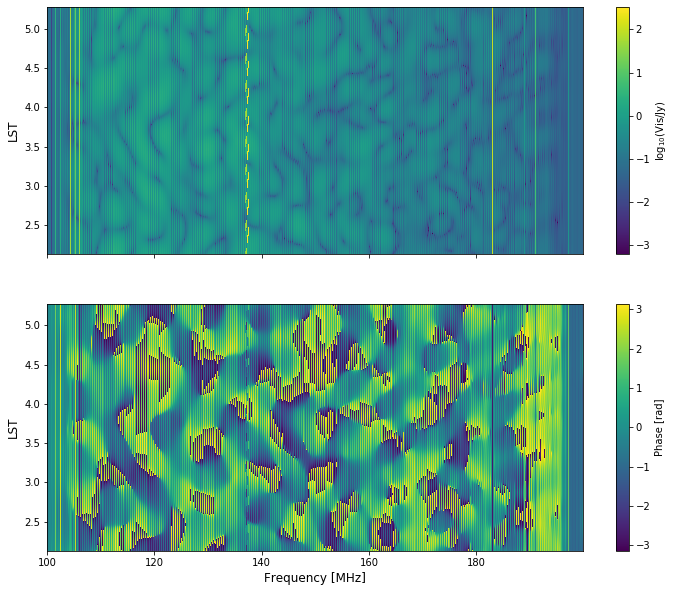

In [36]:
# let's see what it looks like
waterfall(sim.data.data_array)

In [37]:
# and look at its history
print(sim.data.history)

  Downselected to specific antenna pairs using pyuvdata.
hera_sim v0.0.1: Added eor using noiselike_eor with kwargs: {'eor_amp': 0.003}
hera_sim v0.0.1: Added foregrounds using diffuse_foreground with kwargs: {'Tsky_mdl': <hera_sim.interpolators.Tsky object at 0x7f8fb38c02e8>}
hera_sim v0.0.1: Added foregrounds using pntsrc_foreground with kwargs: {'nsrcs': 2500, 'Smin': 0.03}
hera_sim v0.0.1: Added rfi using rfi_stations with kwargs: {}
hera_sim v0.0.1: Added gains with kwargs: {}
hera_sim v0.0.1: Added sigchainreflections with kwargs: {'amp': [0.87, 0.54], 'dly': [13, 8], 'phs': [1.23, 4.56]}
hera_sim v0.0.1: Added xtalk using gen_whitenoise_xtalk with kwargs: {'amplitude': 0.01}


In [38]:
# for those of you unfamiliar with YAML files, here's what the configuration file looks like
with open(tmp_sim_file, 'r') as sim_file:
    print(sim_file.read())


        diffuse_foreground: 
            Tsky_mdl: 
                file: /home/bobby/HERA/dev/make_data/hera_sim/hera_sim/data/HERA_Tsky_Reformatted.npz
                pol: yy
        pntsrc_foreground: 
            nsrcs: 2500
            Smin: 0.03
        noiselike_eor:
            eor_amp: 0.003
        gains: {}
        sigchain_reflections:
            amp: [0.87, 0.54]
            dly: [13, 8]
            phs: [1.23, 4.56]
        rfi_stations: {}
        gen_whitenoise_xtalk:
            amplitude: 0.01
    
